#### Visualization Setup
***

In [38]:
import os
curr_dir = os.getcwd()
base_dir = os.path.dirname(curr_dir)
# Base directory: /project-noteGen
# Current directory: /core  

import numpy as np
import csv
import pandas as pd
import librosa
from scipy.io.wavfile import read as read_wav
from scipy.io.wavfile import write as write_wav
import matplotlib.pyplot as plt
import IPython.display as ipd

import preprocess
import instruments

######
##### Enclosed functions (stored in visualize.py):
> - vis_note_as_original(note_samples, note_labels, ds_factor=None, title=None, window='relative')
> - vis_note_as_sampled(note_samples, title='Note Samples')
> - vis_notes_as_original(notes_samples, notes_labels, ds_factors=None, title='Notes Samples', titles=None, window='relative')
> - vis_notes_as_sampled(notes_samples, title='Notes Samples', titles=None)

#####
#### Note Amplitudes over Timesteps
***

In [39]:
# Plots samples for a single note over timesteps under original sampling
# Only works for whole downsampling factors

def vis_note_as_original(note_samples, note_labels, ds_factor=None, title=None, window='relative'):
    """
    Inputs:
        note_samples: samples for the note
        note_labels: labels for the note
        ds_factor: whole factor source song has been downsampled by:
                     for 22050 kHz, ds_factor = 44100 / 22050 = 2
                    *only works for whole downsampling rates, otherwise use "vis_note_as_sampled"
        title: if specified, otherwise uses note_labels information
        window: choose to display 'relative' timesteps or 'absolute' timesteps from song
    Outputs:
        None
    """
    # check if notes & labels are from custom dataset
    if note_labels.size > 7:
        note_labels = np.delete(note_labels, [0, 1])

    if window == 'absolute':
        timesteps = np.arange(note_labels[0], note_labels[1])
    else:
        timesteps = np.arange(note_labels[1]-note_labels[0])
                                
    if title is None:
        title = f"{instruments.get[note_labels[2]]} Note - Key {note_labels[3]}"
    else:
        title = title
    
    if ds_factor is not None:
        adjusted_samples = np.empty(timesteps.size)
        adjusted_samples[:] = np.nan
        j = 0
        for i in range(timesteps.size):
            if i % ds_factor == 0 and j < note_samples.size:
                adjusted_samples[i] = note_samples[j]
                j += 1
        assert abs(note_samples.size - j) < 5, "Non-matching labels window, or " \
                    "downsampling factor not whole or does not match samples"
        note_samples = adjusted_samples
    
    fig, ax = plt.subplots()
    ax.scatter(timesteps[np.isfinite(note_samples)], note_samples[np.isfinite(note_samples)], s=0.5)
    ax.plot(timesteps[np.isfinite(note_samples)], note_samples[np.isfinite(note_samples)], linewidth=0.1)
    ax.set(xlabel='timesteps', ylabel='amplitudes', title=title)
    #ax.ticklabel_format(style='plain')
    plt.show()

In [40]:
# Plots samples for a single note over timesteps under current sampling
# Number of sampled timesteps depend on song's downsampling rate

def vis_note_as_sampled(note_samples, title='Note Samples'):
    """
    Inputs:
        note_samples: samples for the note
        title: can be specified
    Outputs:
        None
    """
    timesteps = np.arange(note_samples.size)
    fig, ax = plt.subplots()
    ax.scatter(timesteps, note_samples, s=0.5)
    ax.plot(timesteps, note_samples, linewidth=0.1)
    ax.set(xlabel='timesteps', ylabel='amplitudes', title=title)
    plt.show()

In [41]:
# Visualize multiple notes over timesteps under original sampling
# Compare keys, instruments, downsampling, and original against decoded notes
# Input lists must correlate by note, downsampling factors must be whole

def vis_notes_as_original(notes_samples, notes_labels, ds_factors=None, title='Notes Samples', titles=None, window='relative'):
    """
    Inputs:
        notes_samples: list of note samples, containing one inner array for each note
        notes_labels: list of note labels, containing one row of labels for each note
        ds_factors: list of downsampling factors, containing None or whole numbers
        title: overall title
        titles: list of plot titles
        window: choose to display 'relative' timesteps or 'absolute' timesteps from song
    Outputs:
        None
    """
    
    # check if notes & labels are from custom dataset
    for i in range(len(notes_labels)):
        if notes_labels[i].size > 7:
            notes_labels[i] = np.delete(notes_labels[i], [0, 1])
    
    if window == 'absolute':
        notes_timesteps = [np.arange(note_labels[0], note_labels[1]) for note_labels in notes_labels]
    else:
        notes_timesteps = [np.arange(note_labels[1]-note_labels[0]) for note_labels in notes_labels]
    
    notes_samples = notes_samples.copy()
    if ds_factors is not None:
        adjusted_notes_samples = [np.empty(note_timesteps.size) for note_timesteps in notes_timesteps]
        for n, ds_factor in enumerate(ds_factors):
            if ds_factor is None: ds_factor = 1
            adjusted_notes_samples[n][:] = np.nan
            j = 0
            for i in range(notes_timesteps[n].size):
                if i % ds_factor == 0 and j < notes_samples[n].size:
                    adjusted_notes_samples[n][i] = notes_samples[n][j]
                    j += 1
            assert abs(notes_samples[n].size - j) < 5, "Non-matching labels windows, or " \
                    f"downsampling factor not whole or does not match samples [{notes_samples[n].size}, {j}]"
        notes_samples = adjusted_notes_samples
    
    notes_timesteps = [notes_timesteps[i][np.isfinite(notes_samples[i])] for i in range(len(notes_samples))]
    notes_samples = [notes_samples[i][np.isfinite(notes_samples[i])] for i in range(len(notes_samples))]
    
    if titles is None:
        titles = [f"{instruments.get[notes_labels[i][2]]} - Key {notes_labels[i][3]} "
                  f"(Downsampling of {ds_factors[i]})" for i in range(len(notes_samples))]
    else:
        titles = [f"{titles[i]} ({instruments.get[notes_labels[i][2]]} - Key {notes_labels[i][3]})" \
                  for i in range(len(notes_samples))]
        
    fig, axes = plt.subplots(nrows=1, ncols=len(notes_samples), figsize=(34, 11))
    fig.suptitle(title, fontsize=30)

    for i, ax in enumerate(axes):
        ax.scatter(notes_timesteps[i], notes_samples[i], s=1.5)
        ax.plot(notes_timesteps[i], notes_samples[i], linewidth=0.12)
        titles[i] = titles[i].replace("Downsampling of None", "Original samples")
        ax.set(xlabel='timesteps', ylabel='amplitudes', title=titles[i])
        ax.tick_params(labelsize=16)
        ax.xaxis.label.set_size(17)
        ax.yaxis.label.set_size(17)
        ax.title.set_size(21)
    
    plt.show()

In [42]:
# Visualize multiple notes over timesteps under current sampling
# Compare keys, instruments, scaling windows, and original against decoded notes

def vis_notes_as_sampled(notes_samples, title='Notes Samples', titles=None):
    
    """
    Inputs:
        notes_samples: list of note samples, containing one inner array for each note
        title: overall title 
        titles: list of titles for each plot
    Outputs:
        None
    """
    
    notes_samples = notes_samples.copy()
    notes_timesteps = [np.arange(note_sample.size) for note_sample in notes_samples]
    
    if titles is None:
        titles = [i for i in range(len(notes_samples))]
    fig, axes = plt.subplots(nrows=1, ncols=len(notes_samples), figsize=(34, 11))
    fig.suptitle(title, fontsize=30)
    
    for i, ax in enumerate(axes):
        ax.scatter(notes_timesteps[i], notes_samples[i], s=1.5)
        ax.plot(notes_timesteps[i], notes_samples[i], linewidth=0.12)
        ax.set(xlabel='timesteps', ylabel='amplitudes', title=titles[i])
        ax.tick_params(labelsize=16)
        ax.xaxis.label.set_size(17)
        ax.yaxis.label.set_size(17)
        ax.title.set_size(21)
    
    plt.show()

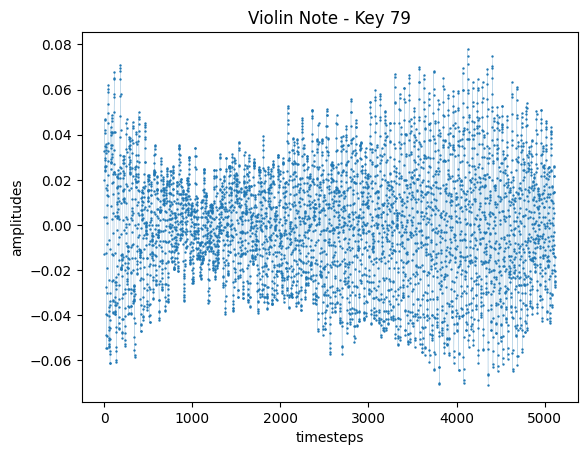

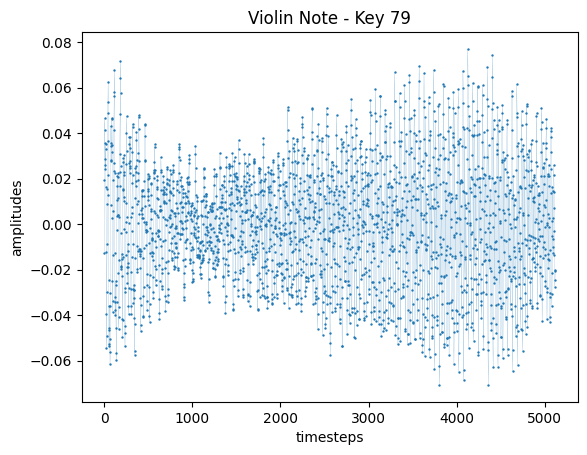

In [43]:
# view single notes

raw_2244 = read_wav(f"{base_dir}/data/downsampling_comparisons/2244_downsampled_0x.wav")
labels_2244 = pd.read_csv(f"{base_dir}/data/raw/train_labels/2244.csv").to_numpy()
notes_samples_2244 = preprocess.construct_note_samples(raw_2244, labels_2244)

vis_note_as_original(notes_samples_2244[450], note_labels=labels_2244[450], ds_factor=None)
#vis_note_as_sampled(notes_samples_2244[48], title='Sampled Timesteps')
ipd.display(ipd.Audio(notes_samples_2244[450], rate=44100))

raw_2244 = read_wav(f"{base_dir}/data/downsampling_comparisons/2244_downsampled_2x.wav")
labels_2244 = pd.read_csv(f"{base_dir}/data/raw/train_labels/2244.csv").to_numpy()
notes_samples_2244 = preprocess.construct_note_samples(raw_2244, labels_2244, ds_rate=22050)

vis_note_as_original(notes_samples_2244[450], note_labels=labels_2244[450], ds_factor=2)
#vis_note_as_sampled(notes_samples_2244[300], title='Sampled Timesteps')
ipd.display(ipd.Audio(notes_samples_2244[450], rate=22050))

In [44]:
# view multiple notes

_ = preprocess.downsample_wav(f"{base_dir}/data/raw/train_data/2244.wav", \
                          f"{base_dir}/data/downsampling_comparisons/2244_downsampled_4x.wav",
                          rate=44100 / 4)
_ = preprocess.downsample_wav(f"{base_dir}/data/raw/train_data/2208.wav", \
                          f"{base_dir}/data/downsampling_comparisons/2208_downsampled_4x.wav",
                          rate=44100 / 4)

labels_2244 = pd.read_csv(f"{base_dir}/data/raw/train_labels/2244.csv").to_numpy()
labels_2208 = pd.read_csv(f"{base_dir}/data/raw/train_labels/2208.csv").to_numpy()

various = [0, 2, 3, 4]
rates = [None, 44100/2, 44100/3, 44100/4]
various_note_samples_2244 = [None]*4
various_note_samples_2208 = [None]*4

for i in range(4):
    raw_2244 = read_wav(f"{base_dir}/data/downsampling_comparisons/2244_downsampled_{various[i]}x.wav")
    various_note_samples_2244[i] = preprocess.construct_note_samples(raw_2244, labels_2244, rates[i])
    
    raw_2208 = read_wav(f"{base_dir}/data/downsampling_comparisons/2208_downsampled_{various[i]}x.wav")
    various_note_samples_2208[i] = preprocess.construct_note_samples(raw_2208, labels_2208, rates[i])

violin_notes_samples = [note_samples_2244[48] for note_samples_2244 in various_note_samples_2244]
violin_notes_labels = [labels_2244[48] for i in range(4)]

piano_notes_samples = [note_samples_2208[726] for note_samples_2208 in various_note_samples_2208]
piano_notes_labels = [labels_2208[726] for i in range(4)]

title_2244 = "Violin High Note (Song #2244, Note #49)"
title_2208 = "Piano Low Note (Song #2208, Note #727)"
factors = [None, 2, 3, 4]

In [45]:
raw_2208 = read_wav(f"{base_dir}/data/raw/train_data/2208.wav")
notes_samples = preprocess.construct_note_samples(raw_2208, labels_2208)
write_wav(f"{base_dir}/data/downsampling_comparisons/2208_vis_piano_note_727.wav", 44100, notes_samples[726])

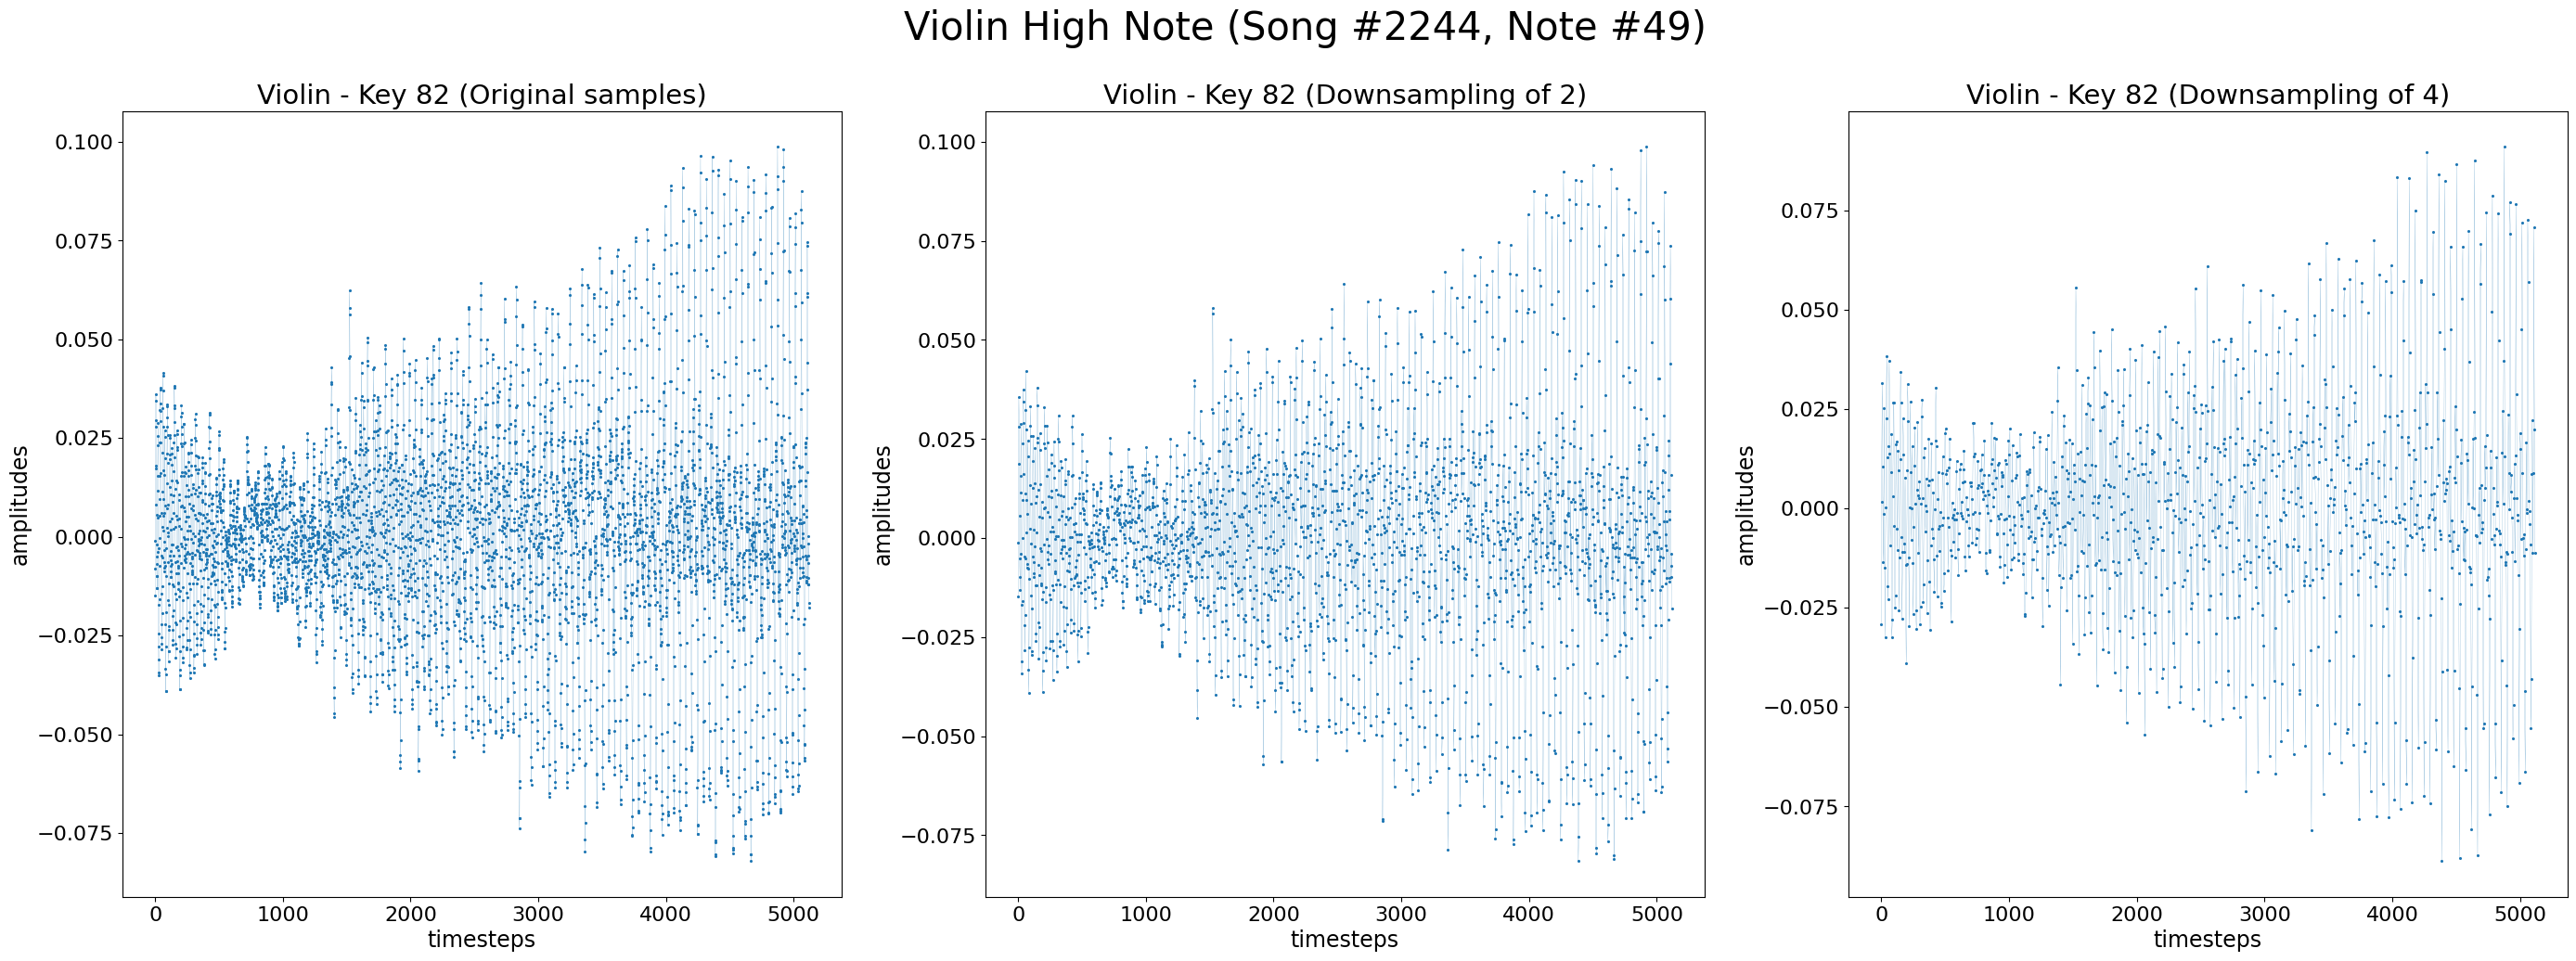

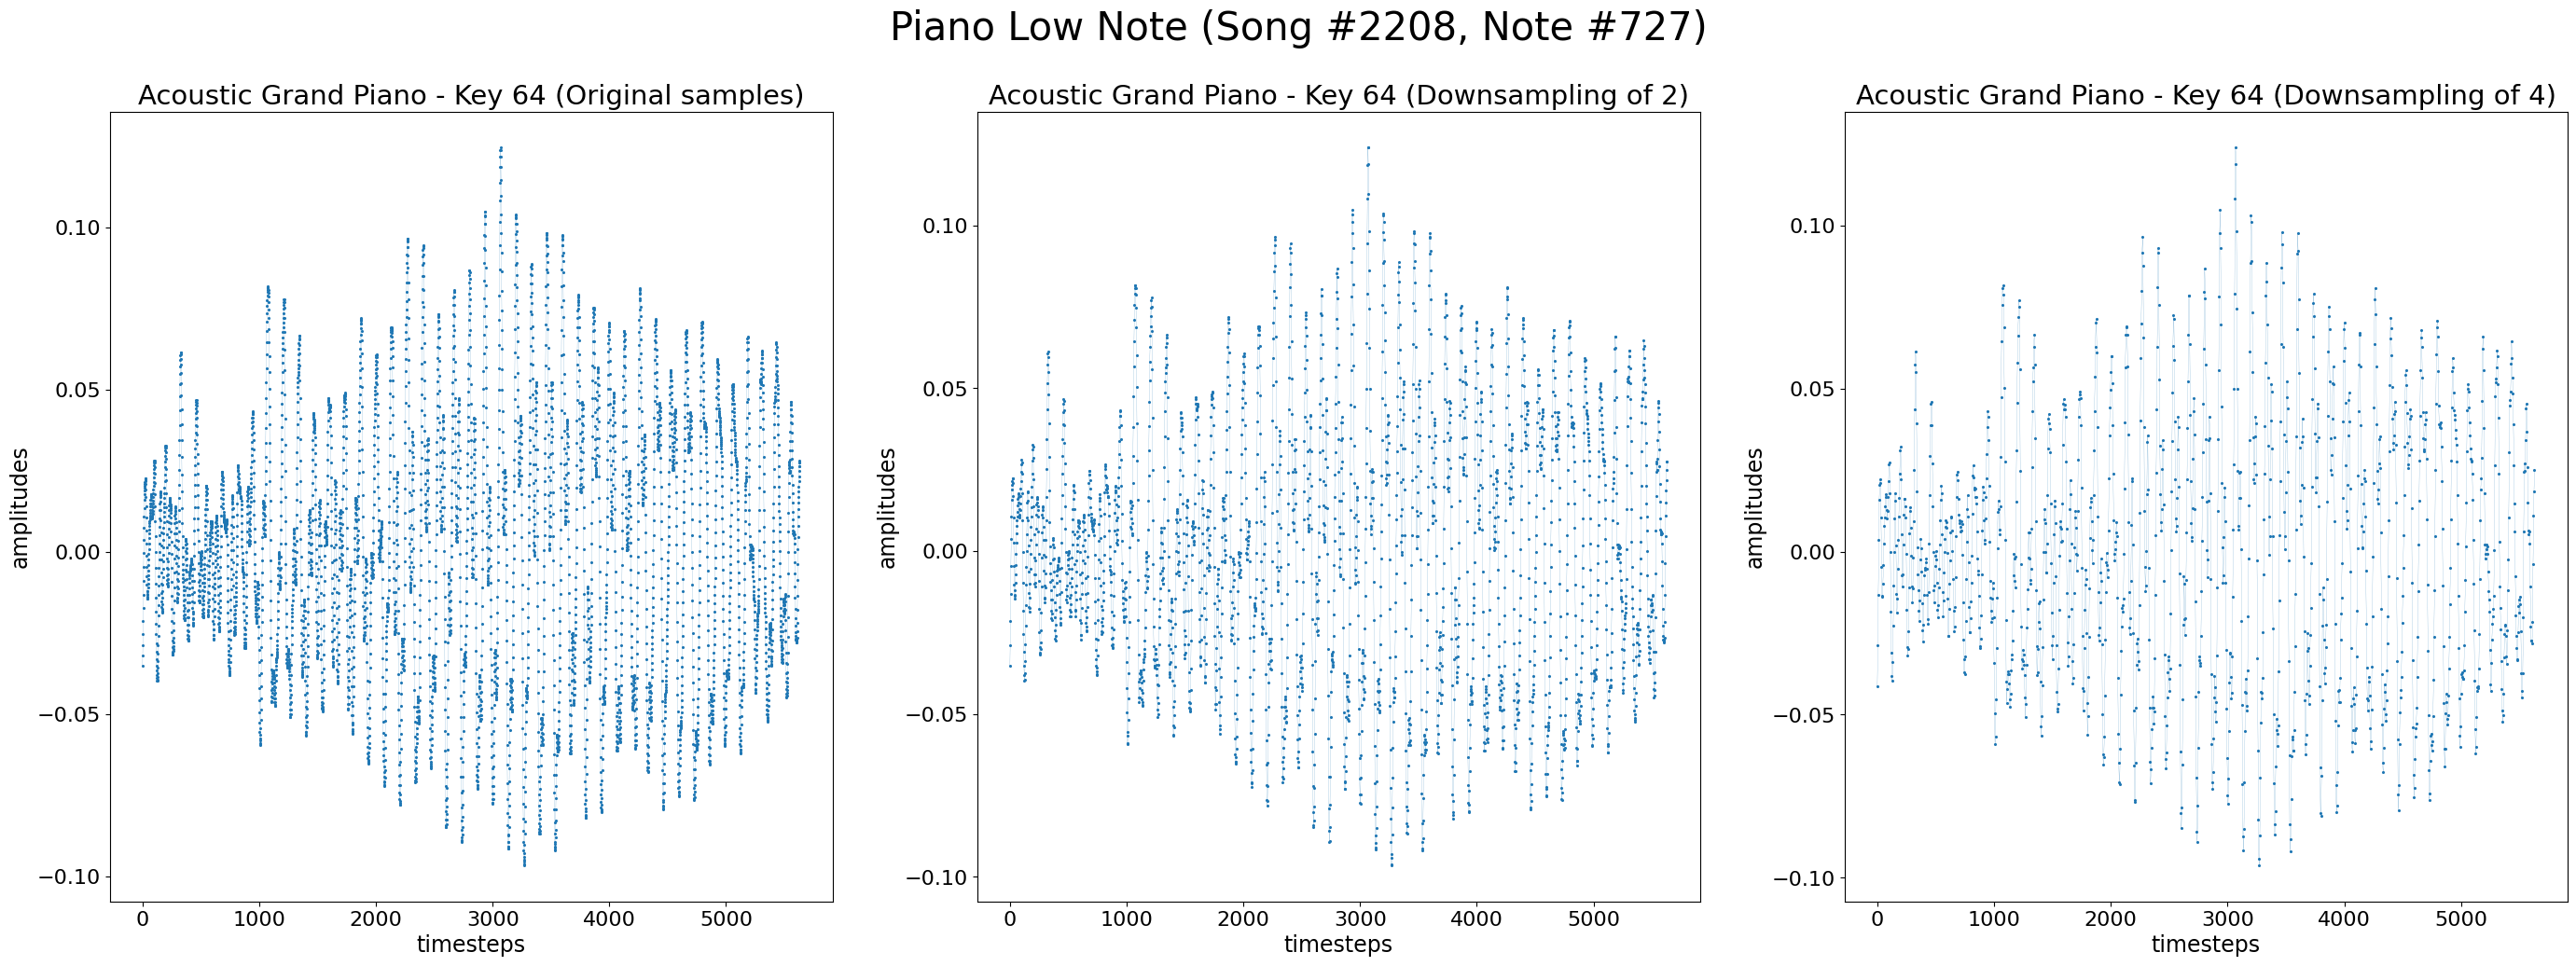

In [46]:
# Comment out to include 3
if len(factors) == 4:
    violin_notes_samples.pop(2)
    violin_notes_labels.pop(2)
    piano_notes_samples.pop(2)
    piano_notes_labels.pop(2)
    factors.pop(2)
    
vis_notes_as_original(violin_notes_samples, violin_notes_labels, factors, title_2244)
vis_notes_as_original(piano_notes_samples, piano_notes_labels, factors, title_2208)

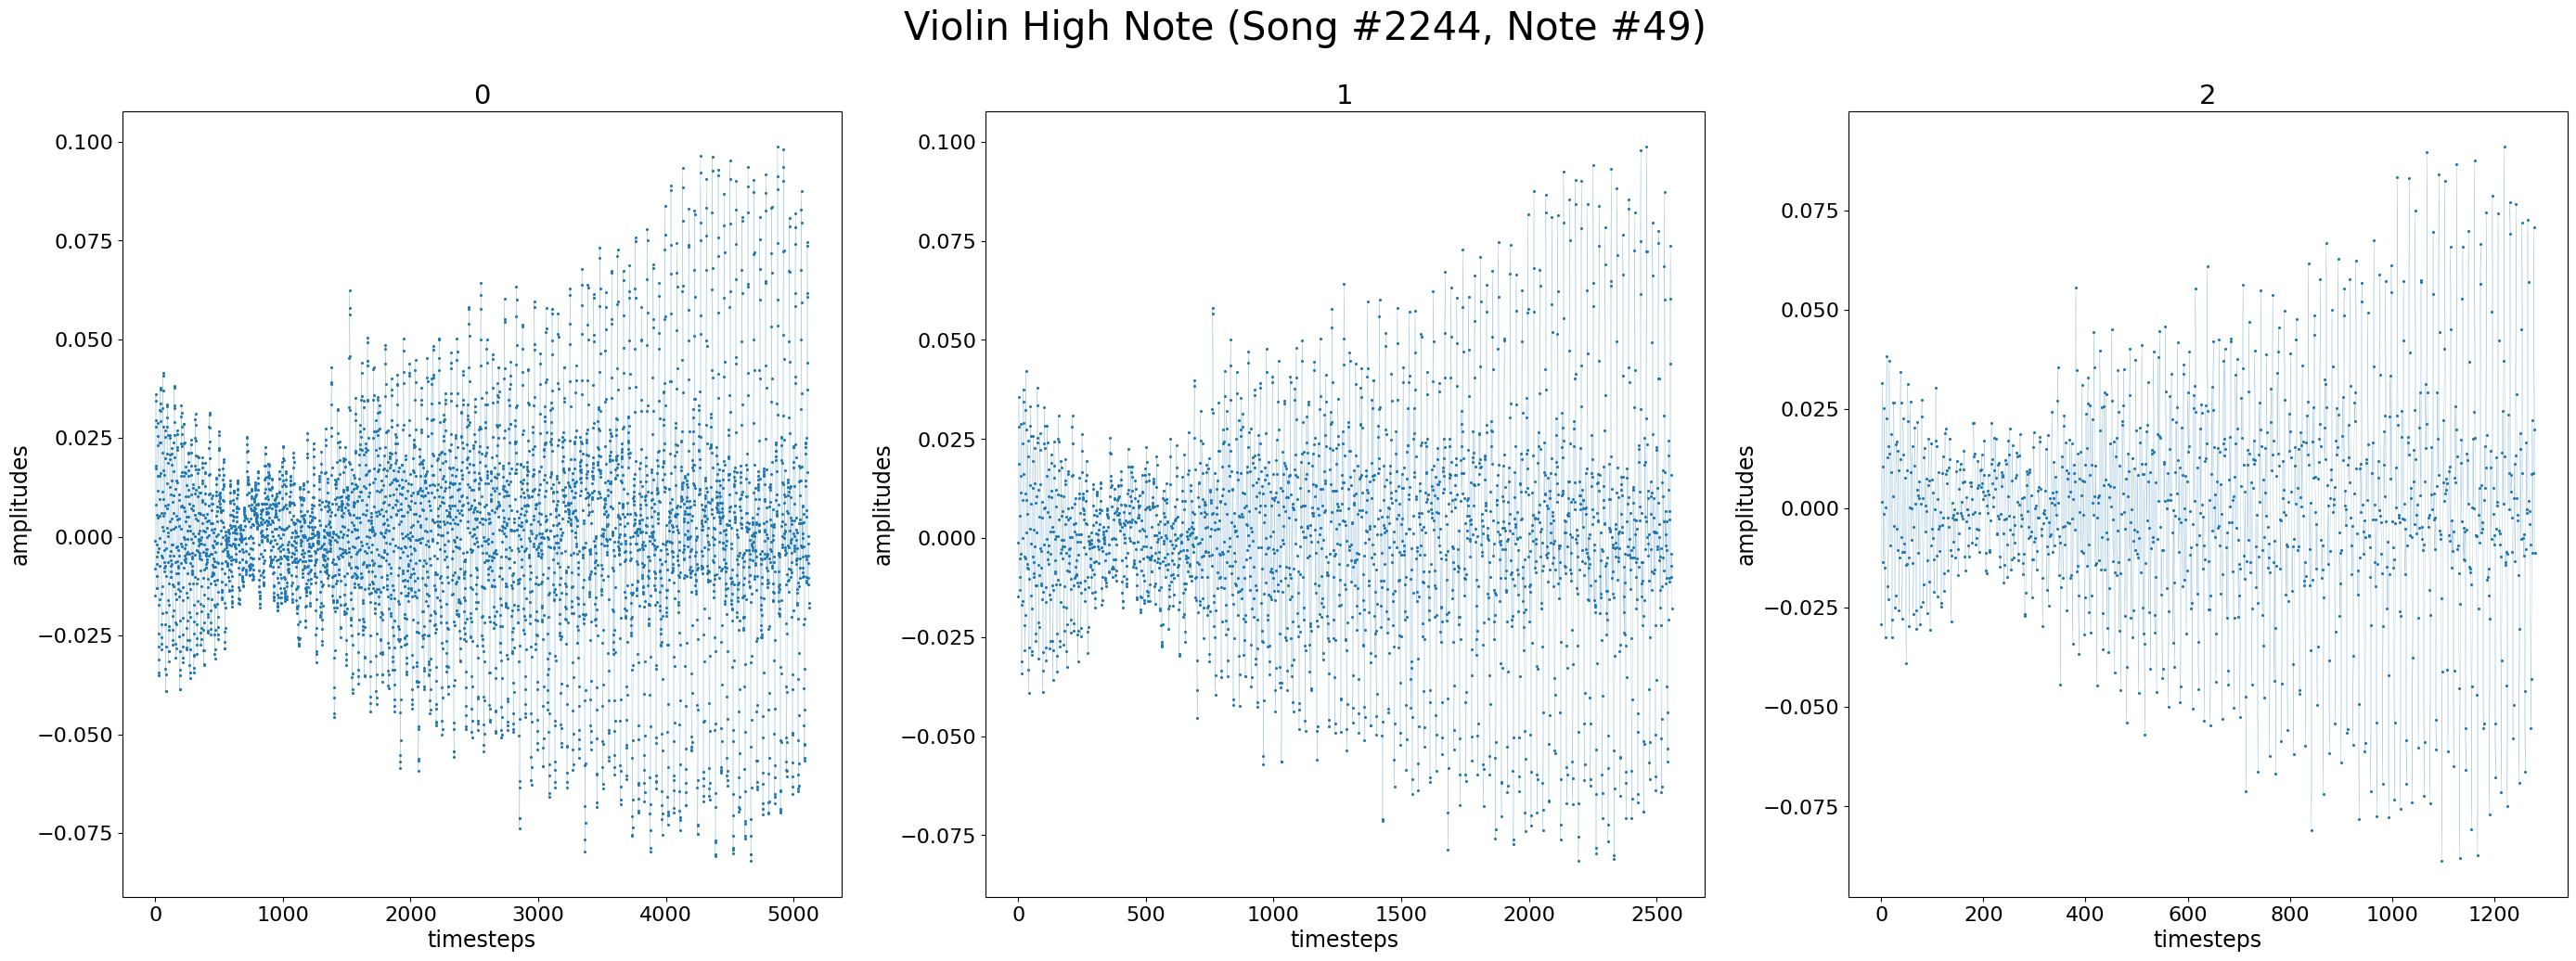

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

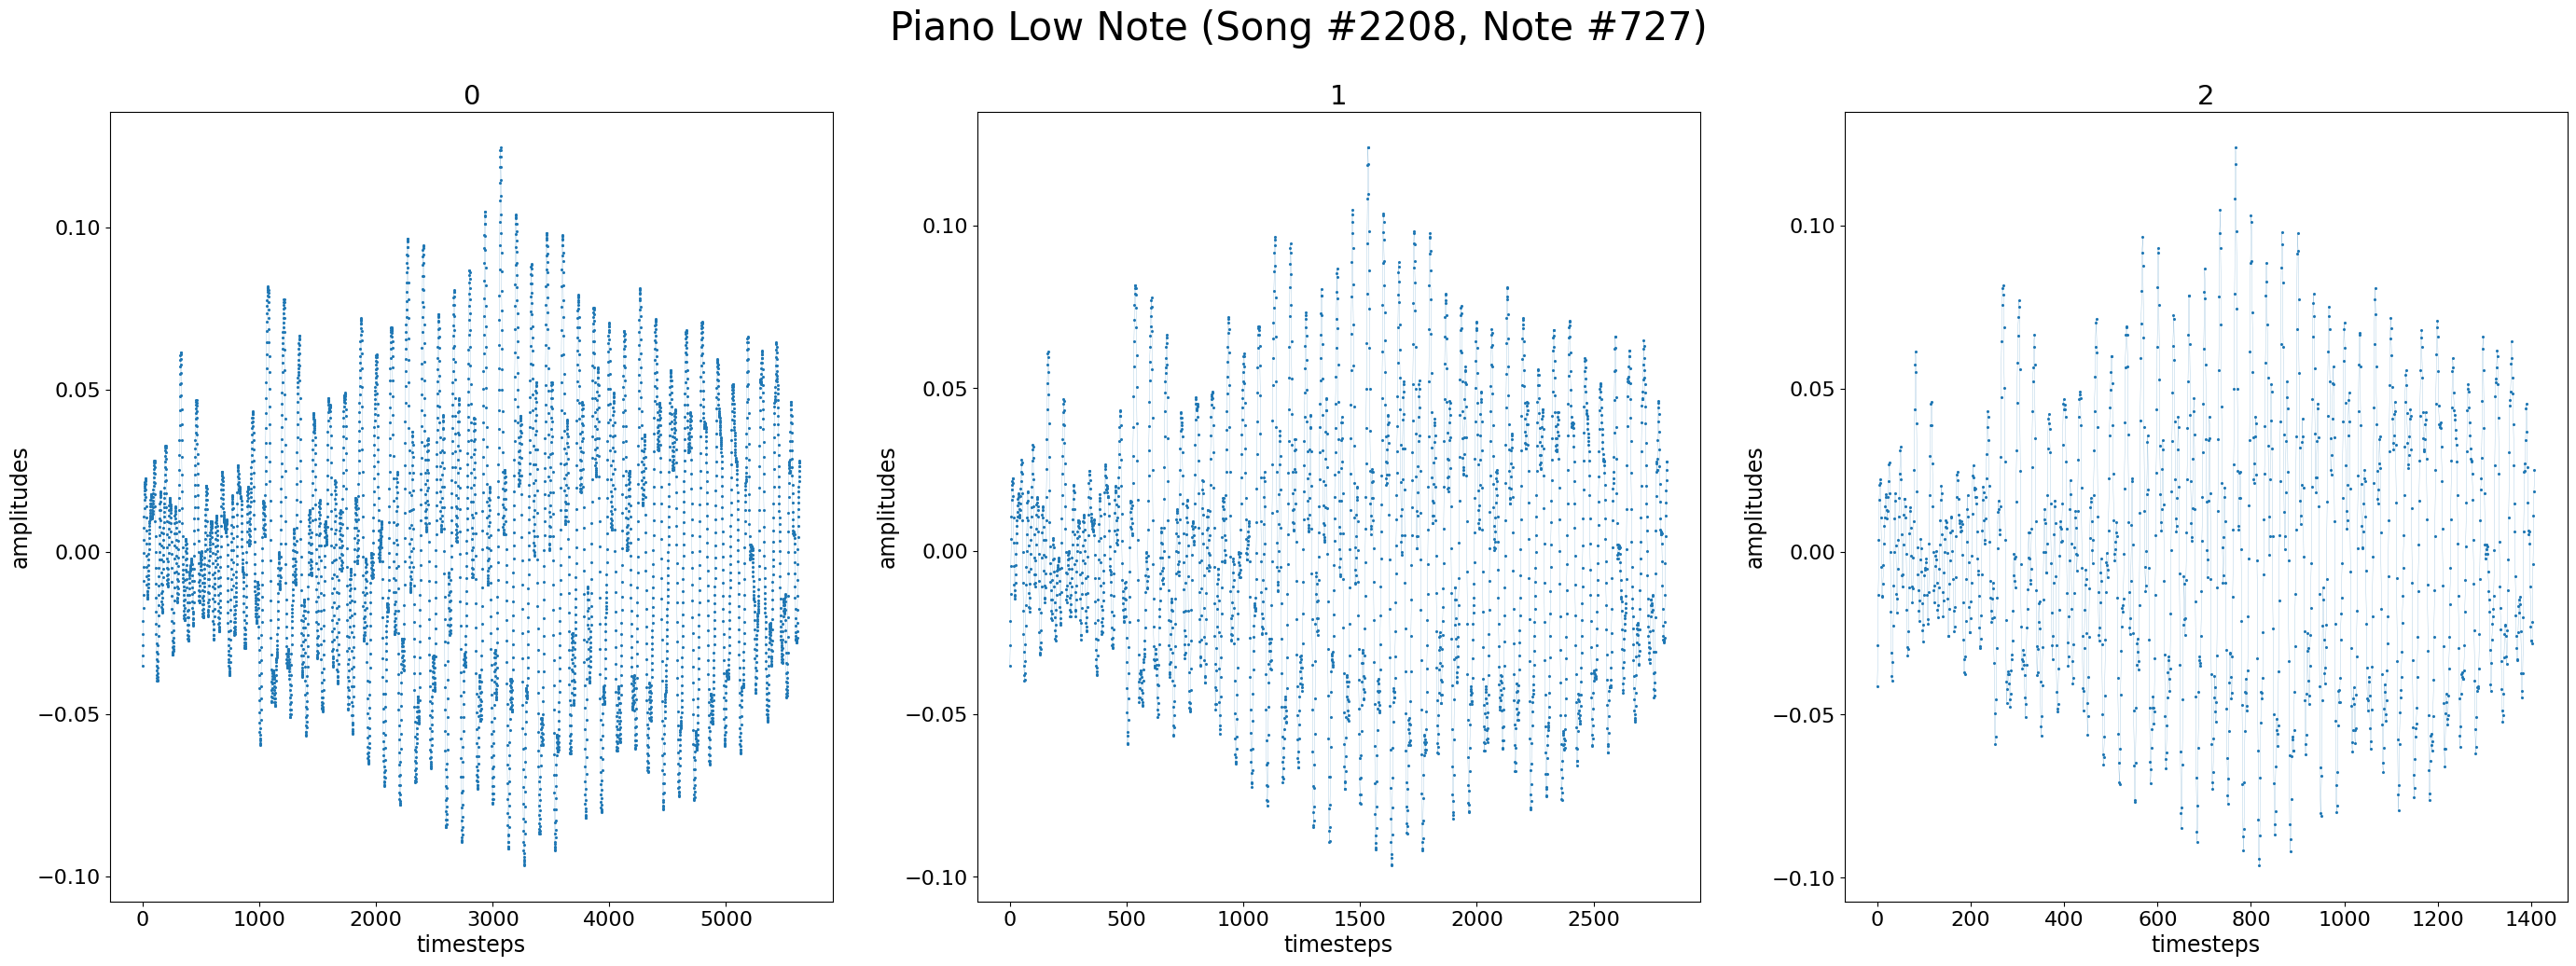

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

In [47]:
# Visualize over sampled timesteps
from visualize import play_notes

factors[factors is None] = 1

vis_notes_as_sampled(violin_notes_samples, title_2244)
play_notes(violin_notes_samples, (44100 / np.array(factors)).astype(int))
    
vis_notes_as_sampled(piano_notes_samples, title_2208)
play_notes(piano_notes_samples, (44100 / np.array(factors)).astype(int))

In [48]:
"""
np.save(f"{base_dir}/data/general/violin_note_samples_0-2-4", violin_notes_samples, allow_pickle=True)
np.save(f"{base_dir}/data/general/piano_note_samples_0-2-4", piano_notes_samples, allow_pickle=True)
np.save(f"{base_dir}/data/general/violin_note_labels_0-2-4", violin_notes_labels, allow_pickle=True)
np.save(f"{base_dir}/data/general/piano_note_labels_0-2-4", piano_notes_labels, allow_pickle=True)
"""

'\nnp.save(f"{base_dir}/data/general/violin_note_samples_0-2-4", violin_notes_samples, allow_pickle=True)\nnp.save(f"{base_dir}/data/general/piano_note_samples_0-2-4", piano_notes_samples, allow_pickle=True)\nnp.save(f"{base_dir}/data/general/violin_note_labels_0-2-4", violin_notes_labels, allow_pickle=True)\nnp.save(f"{base_dir}/data/general/piano_note_labels_0-2-4", piano_notes_labels, allow_pickle=True)\n'

#####
#### Typical samples per note

In [49]:
test_label_names = os.listdir(f"{base_dir}/data/raw/test_labels")
train_label_names = os.listdir(f"{base_dir}/data/raw/train_labels")

samples_counts = []
song_i = -1

for test_label_name in test_label_names:
    if test_label_name.endswith(".csv"):
        song_i += 1
        test_label = pd.read_csv(f"{base_dir}/data/raw/test_labels/{test_label_name}").to_numpy()
        samples_counts = np.append(samples_counts, np.mean(test_label[:, 1] - test_label[:, 0]))
        
for train_label_name in train_label_names:
    if train_label_name.endswith(".csv"):
        song_i += 1
        train_label = pd.read_csv(f"{base_dir}/data/raw/train_labels/{train_label_name}").to_numpy()
        samples_counts = np.append(samples_counts, np.mean(train_label[:, 1] - train_label[:, 0]))

print(len(samples_counts))
#np.save(f"{base_dir}/data/general/samples_counts.npy", samples_counts)

330


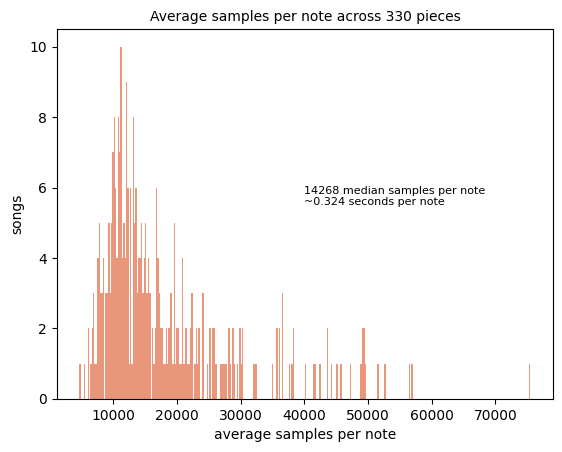

In [50]:
fig, ax = plt.subplots()
ax.hist(samples_counts, bins=330, color='darksalmon')
ax.set(xlabel='average samples per note', ylabel='songs', title='Average samples per note across 330 pieces')
ax.text(40000, 5.5, f'{np.median(samples_counts):.0f} median samples per note\n'
                   f'~{np.median(samples_counts) / 44100:.3f} seconds per note', fontsize=8)
ax.title.set_size(10)
plt.show()

In [51]:
import visualize